In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, RMSprop, SGD

In [3]:
df = pd.read_csv("./processed_adhdata.csv")
df['Class'] = LabelEncoder().fit_transform(df['Class'])  # ADHD->1, Control->0

frequency_count = len(df['Frequency'].unique())
window_count = len(df['Window'].unique())
numeric_df = df.drop(['ID', 'Window'], axis=1)

# shape: (windows, freqs, features)
full_ndarray = numeric_df.values.reshape(
    (window_count, frequency_count, numeric_df.shape[1])
)

X = full_ndarray[:, :, 2:]     # drop ID/Class columns
y = full_ndarray[:, 0, 0]      # class label is repeated across freq rows

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Add channel dimension (N, 1, freq, electrodes)
X_train = X_train[..., np.newaxis]   # (N, freq, electrodes, 1)
X_test  = X_test[...,  np.newaxis]

# Standardize across the entire dataset
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat  = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

X_train = X_train_scaled.reshape(X_train.shape)
X_test  = X_test_scaled.reshape(X_test.shape)

print("Train shape:", X_train.shape)  # (N, freq, electrodes, 1)

Train shape: (6623, 77, 19, 1)


In [26]:
class EEGDatasetGRU(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, freq, electrodes)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = EEGDatasetGRU(X_train, y_train)
test_ds  = EEGDatasetGRU(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

In [31]:
class EEG_GRU(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2,
                 dropout=0.3, num_classes=2):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch, seq_len=freq, features=electrodes)
        if x.dim() == 4:
            x = x.squeeze(-1)  # (batch, freq, electrodes)
        out_seq, h_n = self.gru(x)     # h_n: (num_layers, batch, hidden)
        out = h_n[-1]                  # last layer hidden state
        return self.fc(out)            # raw logits

    def fit(self, train_loader, val_loader, epochs,
            criterion, optimizer, device="cpu", patience=30):
        best_val_loss = float('inf')
        no_improve = 0
        best_state = None

        train_losses, val_losses = [], []
        train_accs,  val_accs  = [], []

        for epoch in range(epochs):
            # ---- Train ----
            self.train()
            train_loss, train_correct = 0.0, 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                out = self(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * xb.size(0)
                train_correct += (out.argmax(1) == yb).sum().item()

            train_loss /= len(train_loader.dataset)
            train_acc  = train_correct / len(train_loader.dataset)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # ---- Validate ----
            self.eval()
            val_loss, val_correct = 0.0, 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = self(xb)
                    loss = criterion(out, yb)
                    val_loss += loss.item() * xb.size(0)
                    val_correct += (out.argmax(1) == yb).sum().item()

            val_loss /= len(val_loader.dataset)
            val_acc  = val_correct / len(val_loader.dataset)
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print(f"Epoch {epoch+1:03d} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if val_loss - train_loss > 0.25:
                print("Overfitting detected.")
                break
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = self.state_dict()
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print("Early stopping triggered.")
                    break

        if best_state:
            self.load_state_dict(best_state)

        return {
            "train_losses": np.array(train_losses),
            "val_losses":   np.array(val_losses),
            "train_accs":   np.array(train_accs),
            "val_accs":     np.array(val_accs)
        }


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_GRU(input_size=X_train.shape[2],
                 hidden_size=64,
                 num_layers=2,
                 dropout=0.3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

history = model.fit(train_loader, test_loader,
                    epochs=200,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device,
                    patience=30)


Epoch 001 | Train Loss: 0.6887 Acc: 0.5537 | Val Loss: 0.6865 Acc: 0.5586
Epoch 002 | Train Loss: 0.6868 Acc: 0.5582 | Val Loss: 0.6862 Acc: 0.5586
Epoch 003 | Train Loss: 0.6867 Acc: 0.5582 | Val Loss: 0.6865 Acc: 0.5586
Epoch 004 | Train Loss: 0.6868 Acc: 0.5582 | Val Loss: 0.6863 Acc: 0.5586
Epoch 005 | Train Loss: 0.6867 Acc: 0.5582 | Val Loss: 0.6864 Acc: 0.5586
Epoch 006 | Train Loss: 0.6867 Acc: 0.5582 | Val Loss: 0.6864 Acc: 0.5586
Epoch 007 | Train Loss: 0.6866 Acc: 0.5582 | Val Loss: 0.6866 Acc: 0.5586
Epoch 008 | Train Loss: 0.6866 Acc: 0.5582 | Val Loss: 0.6864 Acc: 0.5586
Epoch 009 | Train Loss: 0.6866 Acc: 0.5582 | Val Loss: 0.6856 Acc: 0.5586
Epoch 010 | Train Loss: 0.6863 Acc: 0.5584 | Val Loss: 0.6852 Acc: 0.5586
Epoch 011 | Train Loss: 0.6596 Acc: 0.6117 | Val Loss: 0.6248 Acc: 0.6793
Epoch 012 | Train Loss: 0.6008 Acc: 0.6929 | Val Loss: 0.5978 Acc: 0.6975
Epoch 013 | Train Loss: 0.5795 Acc: 0.7045 | Val Loss: 0.5745 Acc: 0.7071
Epoch 014 | Train Loss: 0.5658 Acc: 0.

In [33]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("\nTest Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.7771739130434783
              precision    recall  f1-score   support

           0       0.73      0.95      0.83       925
           1       0.89      0.56      0.69       731

    accuracy                           0.78      1656
   macro avg       0.81      0.75      0.76      1656
weighted avg       0.80      0.78      0.77      1656

[[876  49]
 [320 411]]


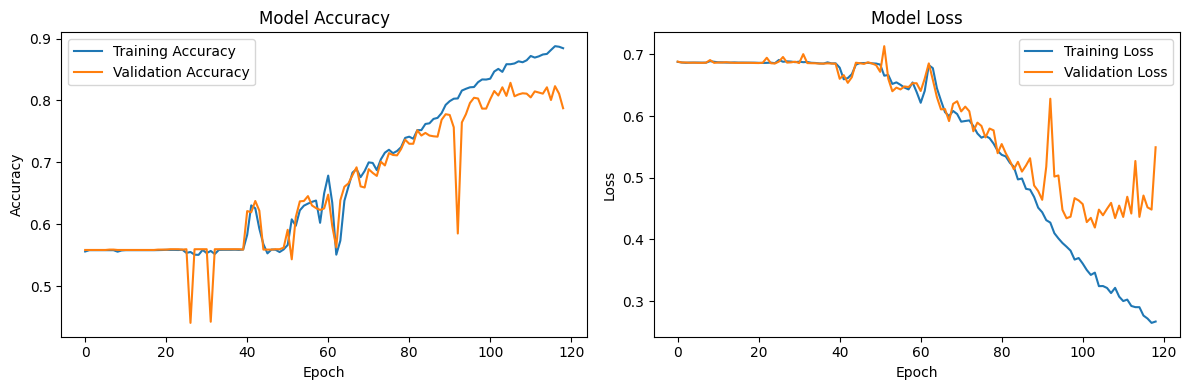

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_accs'], label='Training Accuracy')
plt.plot(history['val_accs'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()